## Importación de Librerías

In [1]:
import open3d as o3d
import numpy as np
import pandas as pd
import os
import re
from glob import glob
import time
import random
import seaborn as sns
import xml.etree.ElementTree as ET
from mpl_toolkits.mplot3d import Axes3D
from pyntcloud import PyntCloud
import plotly.graph_objs as gow
from matplotlib.pyplot import cm
import matplotlib.pyplot as plt 
from plotly.offline import iplot, init_notebook_mode

from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
from torchmetrics.classification import MulticlassMatthewsCorrCoef
import torch.optim as optim
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings("ignore")

init_notebook_mode(connected=True)
%matplotlib inline

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## DataLoader

In [64]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from scipy.spatial import cKDTree

MEAN_REMISSION = 18.9969
STD_REMISSION = 18.4599

category_mapping = {
    0: [7, 22, 9, 26, 11, 21, 51, 50, 5, 18, 23, 3, 24, 31, 2],  # Drivable (Road, Drivable Vegetation, Terrain)
    1: [43, 38, 58, 29, 41, 42, 44, 39, 55,  # Construction
        4, 45, 6, 40, 60, 61, 33, 32, 14,   # Object
        48, 47, 1, 19, 46, 10, 25,         # Sign
        28, 27, 62, 52, 16, 30, 59, 17,    # Non Drivable Vegetation
        13, 15, 12, 36, 57, 49, 20, 35, 37, 34, 63],  # Vehicle
    2: [8, 56, 0, 53, 54],  # Void
}

category_mapping_2 = {
    0: [43, 38, 58, 29, 41, 42, 44, 39, 55], # Construction
    1: [4, 45, 6, 40, 60, 61, 33, 32, 14], # Object
    2: [7, 22, 9, 26, 11, 21], # Road
    3: [48, 47, 1, 19, 46, 10, 25], # Sign
    4: [23, 3, 24, 31, 2], # Terrain  
    5: [51, 50, 5, 18], # Drivable Vegetation
    6: [28, 27, 62, 52, 16, 30, 59, 17], # Non Drivable Vegetation
    7: [13, 15, 12, 36, 57, 49, 20, 35, 37, 34, 63], # Vehicle
    8: [8, 56, 0, 53, 54], # Void
}

# Generar el diccionario inverso para mapear etiquetas
label_to_category = {label: cat for cat, labels in category_mapping_2.items() for label in labels}

# Función para remapear etiquetas
def map_labels(labels: np.ndarray) -> np.ndarray:
    return np.array([label_to_category.get(label, 8) for label in labels], dtype=np.uint8)

def load_bin_file(bin_path: str, num_points: int, radius: float = 25.0, seed: int = None):
    full_points = np.fromfile(bin_path, dtype=np.float32).reshape(-1, 4)
    points = full_points[:, :3]
    remission = full_points[:, 3]  # Añadir remission (shape: [N, 1])

    distances = np.linalg.norm(points, axis=1)
    mask = distances <= radius
    points = points[mask]
    remission = remission[mask]  # Filtrar remission también
    num_available = points.shape[0]

    if num_available >= num_points:
        if seed is not None:
            np.random.seed(seed)  # Establece semilla si se proporciona
        indices = np.random.choice(num_available, num_points, replace=False)
        return points[indices], remission[indices], np.where(mask)[0][indices]

    return None, None, None

def load_label_file(label_path: str, indices: np.ndarray) -> np.ndarray:
    labels = np.fromfile(label_path, dtype=np.uint32) & 0xFFFF
    return map_labels(labels[indices])

def normalize_point_cloud(points):
    mean = np.mean(points, axis=0)  # Media por dimensión
    std = np.std(points, axis=0) + 1e-6  # Evitar divisiones por 0
    return (points - mean) / std

class GOOSEDataset(Dataset):
    def __init__(self, x_path, y_path, num_points=4096, mode='train', batch_size=32):
        self.x_files = sorted([os.path.join(x_path, f) for f in os.listdir(x_path) if f.endswith(".bin")])
        self.y_files = sorted([os.path.join(y_path, f) for f in os.listdir(y_path) if f.endswith(".label")])
        assert len(self.x_files) == len(self.y_files), "Número de archivos de entrada y etiquetas no coinciden"
        self.num_points = num_points
        self.batch_size = batch_size
        self.mode = mode

    def __len__(self):
        return len(self.x_files)

    def __getitem__(self, idx):
        seed = 42 if self.mode == 'val' else None  # Semilla fija para validación
        
        points, remission, indices = load_bin_file(self.x_files[idx], self.num_points, radius=25.0, seed=seed)

        if points is None or indices is None:
            return self.__getitem__((idx + 1) % len(self.x_files))
        
        labels = load_label_file(self.y_files[idx], indices)

        if labels is None:
            return self.__getitem__((idx + 1) % len(self.x_files))
        
        remission = (torch.tensor(remission, dtype=torch.float32) - MEAN_REMISSION) / STD_REMISSION

        return torch.tensor(points, dtype=torch.float32), remission, torch.tensor(labels, dtype=torch.long)

In [57]:
x_train_path = "/home/fmartinez/datasets/goose/lidar/train"
y_train_path = "/home/fmartinez/datasets/goose/labels/train"

x_val_path = "/home/fmartinez/datasets/goose/lidar/val"
y_val_path = "/home/fmartinez/datasets/goose/labels/val"

x_test_path = "/home/fmartinez/datasets_val/lidar/val"
y_test_path = "/home/fmartinez/datasets_val/labels/val"

In [58]:
train_dataset = GOOSEDataset(x_train_path, y_train_path, num_points=16384, mode='train', batch_size=16)
val_dataset = GOOSEDataset(x_val_path, y_val_path, num_points=16384, mode='val', batch_size=16)

In [59]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [29]:
import plotly.graph_objects as go
import pandas as pd

def plot_3D_colors(sampled_df):
    # Define color map for 3 categories
    color_map = {
        0: 'limegreen',  # Drivable (Green for clear zones)
        1: 'red',        # Obstacle (Red for danger/obstacles)
        2: 'gray'        # Void (Gray for undefined points)
    }

    color_map_2 = {
        0: 'yellow',  # Drivable (Green for clear zones)
        1: 'red',        # Obstacle (Red for danger/obstacles)
        2: 'gray',        # Void (Gray for undefined points)
        3: 'black',      # Drivable (Green for clear zones)
        4: 'blue',        # Obstacle (Red for danger/obstacles)
        5: 'green',       # Void (Gray for undefined points)
        6: 'limegreen',  # Drivable (Green for clear zones)
        7: 'purple',        # Obstacle (Red for danger/obstacles)
        8: 'white'        # Void (Gray for undefined points)
    }

    label_categories = [
        'Drvable',  # 0
        'Obstacle',  # 1
        'Void' # 2
    ]

    label_categories_2 = [
        'yellow',  # Drivable (Green for clear zones)
        'red',        # Obstacle (Red for danger/obstacles)
        'gray',        # Void (Gray for undefined points)
        'black',      # Drivable (Green for clear zones)
        'blue',        # Obstacle (Red for danger/obstacles)
        'green',       # Void (Gray for undefined points)
        'limegreen',  # Drivable (Green for clear zones)
        'purple',        # Obstacle (Red for danger/obstacles)
        'white'        # Void (Gray for undefined points)
    ]

    # Map label colors using apply to avoid NaN issues
    scatter_colors = sampled_df['label'].apply(lambda x: color_map_2.get(x, 'gray'))
    scatter_texts = sampled_df['label'].apply(lambda x: label_categories_2[x])  #  Nombre de la clase

    # Create a 3D scatter plot without adding it to the legend
    fig = go.Figure()

    fig.add_trace(go.Scatter3d(
        x=sampled_df['x'],
        y=sampled_df['y'],
        z=sampled_df['z'],
        mode='markers',
        marker=dict(
            size=2,  # Ajustar tamaño del punto
            color=scatter_colors,  # Color por categoría
            opacity=0.7  # Ajustar opacidad
        ),
        text=scatter_texts,  #  Se muestra el nombre de la clase al pasar el mouse
        hoverinfo="text",  #  Muestra solo el texto en hover
        showlegend=False  # Evita que los puntos aparezcan en la leyenda
    ))

    # Add legend manually
    for label, color in color_map_2.items():
        fig.add_trace(go.Scatter(
            x=[None], y=[None], mode='markers',
            marker=dict(size=10, color=color),
            name=label_categories_2[label],
            showlegend=True  # Solo estos elementos aparecen en la leyenda
        ))

    # Set labels and title
    fig.update_layout(
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z'
        ),
        title='3D Point Cloud with Label Colors',
        legend_title='Labels'
    )

    fig.show()

In [30]:
# Extract a batch from the train_loader
batch = next(iter(val_loader))

# Separate the point cloud data and labels
point_cloud_batch, remissions, labels_batch = batch

# Select the first sample in the batch (index 0)
sample_point_cloud = point_cloud_batch[0].numpy()
sample_labels = labels_batch[0].numpy()

In [31]:
# Convert the point cloud sample to a DataFrame
sampled_df = pd.DataFrame(sample_point_cloud, columns=['x', 'y', 'z'])
sampled_df['label'] = sample_labels
sampled_df.head()

,x,y,z,label
0,18.439491,4.665908,-1.503641,5
1,4.127188,-8.267016,-0.019349,6
2,13.312873,20.728971,1.179032,6
3,9.383001,-9.016855,-1.104183,6
4,18.586058,-2.787655,-1.922272,5


In [32]:
plot_3D_colors(sampled_df)

## PointNet ++

In [33]:
def farthest_point_sample(xyz, npoint):
    B, N, C = xyz.shape
    centroids = torch.zeros(B, npoint, dtype=torch.long).to(xyz.device)
    distance = torch.ones(B, N).to(xyz.device) * 1e10
    farthest = torch.randint(0, N, (B,), dtype=torch.long).to(xyz.device)
    batch_indices = torch.arange(B, dtype=torch.long).to(xyz.device)

    for i in range(npoint):
        centroids[:, i] = farthest
        centroid = xyz[batch_indices, farthest, :].unsqueeze(1)  # (B, 1, 3)
        dist = torch.sum((xyz - centroid) ** 2, -1)
        mask = dist < distance
        distance[mask] = dist[mask]
        farthest = torch.max(distance, -1)[1]

    return centroids

In [34]:
def square_distance(src, dst):
    B, N, _ = src.shape
    _, M, _ = dst.shape
    dist = -2 * torch.matmul(src, dst.permute(0, 2, 1))
    dist += torch.sum(src ** 2, -1).view(B, N, 1)
    dist += torch.sum(dst ** 2, -1).view(B, 1, M)
    return dist

def query_ball_point(radius, nsample, xyz, new_xyz):
    B, N, _ = xyz.shape
    _, S, _ = new_xyz.shape
    group_idx = torch.arange(N, device=xyz.device).view(1, 1, N).repeat(B, S, 1)
    sqrdists = square_distance(new_xyz, xyz)
    group_idx[sqrdists > radius ** 2] = N
    group_idx = group_idx.sort(dim=-1)[0][:, :, :nsample]
    group_first = group_idx[:, :, 0].view(B, S, 1).repeat(1, 1, nsample)
    group_idx[group_idx == N] = group_first[group_idx == N]
    return group_idx

In [35]:
def sample_and_group(npoint, radius, nsample, xyz, points):
    B, N, C = xyz.shape
    fps_idx = farthest_point_sample(xyz, npoint)
    new_xyz = index_points(xyz, fps_idx)

    idx = query_ball_point(radius, nsample, xyz, new_xyz)
    grouped_xyz = index_points(xyz, idx)  # [B, npoint, nsample, C]
    grouped_xyz_norm = grouped_xyz - new_xyz.unsqueeze(2)

    if points is not None:
        grouped_points = index_points(points, idx)
        new_points = torch.cat([grouped_xyz_norm, grouped_points], dim=-1)
    else:
        new_points = grouped_xyz_norm

    return new_xyz, new_points

def index_points(points, idx):
    """
    points: (B, N, C)
    idx: (B, S) o (B, S, K)
    Return:
        new_points: (B, S, C) o (B, S, K, C)
    """
    B = points.shape[0]
    batch_indices = torch.arange(B, device=points.device).view(B, 1, 1)

    if idx.dim() == 2:
        # idx: (B, S)
        return points[torch.arange(B).view(-1, 1).to(points.device), idx]  # (B, S, C)
    elif idx.dim() == 3:
        # idx: (B, S, K)
        batch_indices = batch_indices.expand(-1, idx.shape[1], idx.shape[2])
        return points[batch_indices, idx]  # (B, S, K, C)
    else:
        raise ValueError("idx debe tener 2 o 3 dimensiones")



In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PointNetSetAbstraction(nn.Module):
    def __init__(self, npoint, radius, nsample, in_channel, mlp, group_all):
        super(PointNetSetAbstraction, self).__init__()
        self.npoint = npoint
        self.radius = radius
        self.nsample = nsample
        self.group_all = group_all

        self.mlp_convs = nn.ModuleList()
        self.mlp_bns = nn.ModuleList()

        last_channel = in_channel
        for out_channel in mlp:
            self.mlp_convs.append(nn.Conv2d(last_channel, out_channel, 1))
            self.mlp_bns.append(nn.BatchNorm2d(out_channel))
            last_channel = out_channel

    def forward(self, xyz, points):
        """
        xyz: (B, 3, N)
        points: (B, D, N)
        """
        B, C, N = xyz.shape

        xyz = xyz.permute(0, 2, 1)  # [B, N, 3]
        if points is not None:
            points = points.permute(0, 2, 1)  # [B, N, D]

        if self.group_all:
            new_xyz, new_points = sample_and_group_all(xyz, points)
        else:
            new_xyz, new_points = sample_and_group(self.npoint, self.radius, self.nsample, xyz, points)

        # new_points: (B, npoint, nsample, C+D)
        new_points = new_points.permute(0, 3, 2, 1)  # (B, C+D, nsample, npoint)

        for i, conv in enumerate(self.mlp_convs):
            bn = self.mlp_bns[i]
            new_points = F.relu(bn(conv(new_points)))

        new_points = torch.max(new_points, 2)[0]        # (B, mlp[-1], npoint)
        new_xyz = new_xyz.permute(0, 2, 1)              # (B, 3, npoint)
        return new_xyz, new_points



In [37]:
class PointNetFeaturePropagation(nn.Module):
    def __init__(self, in_channel, mlp):
        super(PointNetFeaturePropagation, self).__init__()
        self.mlp_convs = nn.ModuleList()
        self.mlp_bns = nn.ModuleList()
        last_channel = in_channel
        for out_channel in mlp:
            self.mlp_convs.append(nn.Conv1d(last_channel, out_channel, 1))
            self.mlp_bns.append(nn.BatchNorm1d(out_channel))
            last_channel = out_channel

    def forward(self, xyz1, xyz2, points1, points2):
        """
        xyz1: [B, 3, N] (target, upsampled)
        xyz2: [B, 3, S] (source, sampled)
        points1: [B, D1, N] (target features)
        points2: [B, D2, S] (source features)
        """
        B, C, N = xyz1.shape
        _, _, S = xyz2.shape

        if S == 1:
            interpolated_points = points2.repeat(1, 1, N)
        else:
            dists = square_distance(xyz1.permute(0, 2, 1), xyz2.permute(0, 2, 1))  # (B, N, S)
            dists, idx = dists.sort(dim=-1)
            dists, idx = dists[:, :, :3], idx[:, :, :3]  # KNN: 3 vecinos

            dist_recip = 1.0 / (dists + 1e-8)
            norm = torch.sum(dist_recip, dim=2, keepdim=True)
            weight = dist_recip / norm

            interpolated_points = torch.sum(index_points(points2.permute(0, 2, 1), idx) * weight.unsqueeze(-1), dim=2)
            interpolated_points = interpolated_points.permute(0, 2, 1)

        if points1 is not None:
            new_points = torch.cat([points1, interpolated_points], dim=1)
        else:
            new_points = interpolated_points

        for i, conv in enumerate(self.mlp_convs):
            bn = self.mlp_bns[i]
            new_points = F.relu(bn(conv(new_points)))

        return new_points

In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PointNet2SemSeg(nn.Module):
    def __init__(self, num_classes=3, normal_channel=False):
        super(PointNet2SemSeg, self).__init__()
        in_channel = 6 if normal_channel else 3

        # Set Abstraction layers (encoder)
        self.sa1 = PointNetSetAbstraction(npoint=1024, radius=1, nsample=32, in_channel=in_channel, mlp=[32, 32, 64], group_all=False)
        self.sa2 = PointNetSetAbstraction(npoint=256, radius=3, nsample=64, in_channel=64 + 3, mlp=[64, 64, 128], group_all=False)
        self.sa3 = PointNetSetAbstraction(npoint=64, radius=9, nsample=256, in_channel=128 + 3, mlp=[128, 128, 256], group_all=False)

        # Feature Propagation layers (decoder)
        self.fp3 = PointNetFeaturePropagation(in_channel=256 + 128, mlp=[256, 256])
        self.fp2 = PointNetFeaturePropagation(in_channel=256 + 64, mlp=[256, 128])
        self.fp1 = PointNetFeaturePropagation(in_channel=128, mlp=[128, 128, 128])

        # MLP profundo para segmentación con remission (entrada: 128+1=129 canales)
        self.conv1 = nn.Conv1d(129, 128, 1)
        self.bn1 = nn.BatchNorm1d(128)
        self.drop1 = nn.Dropout(0.5)

        self.conv2 = nn.Conv1d(128, 64, 1)
        self.bn2 = nn.BatchNorm1d(64)
        self.drop2 = nn.Dropout(0.3)

        self.conv3 = nn.Conv1d(64, 32, 1)
        self.bn3 = nn.BatchNorm1d(32)
        self.drop3 = nn.Dropout(0.3)

        self.conv4 = nn.Conv1d(32, num_classes, 1)

    def forward(self, x, remission, return_l0=False):
        B, _, N = x.shape
        l0_xyz = x
        l0_points = None

        # Encoder
        l1_xyz, l1_points = self.sa1(l0_xyz, l0_points)
        l2_xyz, l2_points = self.sa2(l1_xyz, l1_points)
        l3_xyz, l3_points = self.sa3(l2_xyz, l2_points)

        # Decoder
        l2_points = self.fp3(l2_xyz, l3_xyz, l2_points, l3_points)
        l1_points = self.fp2(l1_xyz, l2_xyz, l1_points, l2_points)
        l0_points = self.fp1(l0_xyz, l1_xyz, l0_points, l1_points)

        # Concatenar remission
        l0_points = torch.cat([l0_points, remission], dim=1)  # (B, 129, N)

        # MLP final con GELU
        x = F.gelu(self.bn1(self.conv1(l0_points)))
        x = self.drop1(x)
        x = F.gelu(self.bn2(self.conv2(x)))
        x = self.drop2(x)
        x = F.gelu(self.bn3(self.conv3(x)))
        x = self.drop3(x)
        x = self.conv4(x)
        x = F.log_softmax(x, dim=1)

        if return_l0:
            return x, l0_points
        return x

In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class PointNetSegLoss(nn.Module):
    def __init__(self, alpha=None, gamma=0, size_average=True, dice=False):
        super(PointNetSegLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.size_average = size_average
        self.dice = dice

        if isinstance(alpha, (float, int)): 
            self.alpha = torch.tensor([alpha, 1 - alpha], dtype=torch.float)
        elif isinstance(alpha, (list, np.ndarray)):
            self.alpha = torch.tensor(alpha, dtype=torch.float)

    def forward(self, predictions, targets):
        """
        predictions: (B*N, C) logits
        targets: (B*N,) class indices
        """
        if self.alpha is not None:
            alpha_t = self.alpha.to(predictions.device)[targets]  # (B*N,)
        else:
            alpha_t = 1.0

        logpt = F.log_softmax(predictions, dim=1)
        pt = torch.exp(logpt)  # (B*N, C)
        logpt_t = logpt.gather(1, targets.unsqueeze(1)).squeeze(1)  # (B*N,)
        pt_t = pt.gather(1, targets.unsqueeze(1)).squeeze(1)        # (B*N,)

        focal_term = (1 - pt_t) ** self.gamma
        loss = -alpha_t * focal_term * logpt_t

        if self.size_average:
            loss = loss.mean()
        else:
            loss = loss.sum()

        if self.dice:
            pred_labels = predictions.argmax(dim=1)  # (B*N,)
            dice_loss = self.dice_loss(pred_labels, targets)
            return loss + dice_loss
        else:
            return loss

    @staticmethod
    def dice_loss(preds, targets, eps=1e-6):
        preds = preds.view(-1)
        targets = targets.view(-1)
        dice = 0.0
        classes = torch.unique(targets)

        for cls in classes:
            pred_cls = (preds == cls).float()
            target_cls = (targets == cls).float()
            intersection = (pred_cls * target_cls).sum()
            union = pred_cls.sum() + target_cls.sum()
            dice += (2. * intersection + eps) / (union + eps)

        return 1 - dice / len(classes)

In [40]:
train_dataset = GOOSEDataset(
    x_path=x_train_path,
    y_path=y_train_path,
    num_points=16384,
    mode='train'
)

val_dataset = GOOSEDataset(
    x_path=x_val_path,
    y_path=y_val_path,
    num_points=16384,
    mode='val'
)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)

In [41]:
num_classes = 9  # numero de agrupaciones
model = PointNet2SemSeg(num_classes=num_classes).cuda()

In [42]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Pesos para la función de pérdida
# [1.36, 11.63, 14.13, 18.82, 1.09, 0.49, 0.20, 6.70, 20.54] ideales, [0.8, 1, 1.8, 1, 0.85, 0.5, 0.3, 1, 1]

alpha = torch.tensor([0.8, 1, 1.8, 1, 0.85, 0.5, 0.3, 1, 1], dtype=torch.float32).to('cuda')
alpha = alpha / alpha.sum()

criterion = nn.NLLLoss(weight=alpha)
# criterion = PointNetSegLoss(alpha=alpha, gamma=2, size_average=True, dice=False)

optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True, min_lr=1e-6)


In [32]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Pesos normalizados para las 9 clases (como los tuyos)
alpha = torch.tensor([1.36, 11.63, 14.13, 18.82, 1.09, 0.49, 0.20, 6.70, 20.54], dtype=torch.float32).to('cuda')
alpha = alpha / alpha.sum()

# Usar tu función de pérdida combinada (CrossEntropy + Focal + opcional Dice)
criterion = PointNetSegLoss(alpha=alpha, gamma=2, size_average=True, dice=False)

# Optimizer y scheduler igual
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True, min_lr=1e-6)


In [43]:
import numpy as np

def compute_accuracy(preds, labels):
    """
    preds: (B*N,) predicted labels
    labels: (B*N,) ground truth labels
    """
    correct = (preds == labels).sum().item()
    total = labels.numel()
    return correct / total

def compute_iou(preds, labels, num_classes=9):
    """
    preds: (B*N,) predicted labels
    labels: (B*N,) ground truth labels
    """
    ious = []
    for cls in range(num_classes):
        pred_cls = (preds == cls)
        label_cls = (labels == cls)
        intersection = (pred_cls & label_cls).sum().item()
        union = (pred_cls | label_cls).sum().item()
        if union == 0:
            ious.append(np.nan)  # clase ausente, no se cuenta en el promedio
        else:
            ious.append(intersection / union)
    return ious

def adjust_class_weights(preds, labels, alpha, num_classes=9):
    # Calcular la matriz de confusión
    conf_matrix = torch.zeros(num_classes, num_classes).cuda()
    for p, t in zip(preds.view(-1), labels.view(-1)):
        conf_matrix[t, p] += 1

    # Calcular el recall por clase
    recall = conf_matrix.diag() / conf_matrix.sum(dim=1)
    recall[recall != recall] = 0  # Ignorar NaN

    # Ajustar pesos basados en el recall
    new_alpha = 1 / (recall + 1e-6)  # Evitar divisiones por cero
    new_alpha = new_alpha / new_alpha.sum()  # Normalizar
    
    return new_alpha

In [44]:
import torch
torch.cuda.empty_cache()

In [60]:
for epoch in range(1, 11):
    model.train()
    running_loss = 0.0
    partial_correct = 0
    partial_seen = 0
    partial_ious = []

    for batch_idx, (points, remission, labels) in enumerate(train_loader):
        points = points.permute(0, 2, 1).cuda()
        remission = remission.permute(0, 2, 1).cuda()
        labels = labels.cuda()

        optimizer.zero_grad()

        preds = model(points, remission)

        preds_flat = preds.permute(0, 2, 1).contiguous().view(-1, preds.shape[1])
        labels_flat = labels.view(-1)  # (B*N,)

        loss = criterion(preds_flat, labels_flat)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Métricas por batch
        pred_labels = preds_flat.argmax(dim=1)
        partial_correct += (pred_labels == labels_flat).sum().item()
        partial_seen += labels_flat.numel()
        ious = compute_iou(pred_labels, labels_flat, num_classes=preds.shape[1])
        partial_ious.append(ious)

        # Mostrar progreso cada 10 batches (sobrescribe la línea)
        if (batch_idx + 1) % 10 == 0 or (batch_idx + 1) == len(train_loader):
            avg_loss = running_loss / (batch_idx + 1)
            avg_acc = partial_correct / partial_seen
            avg_miou = np.nanmean(np.nanmean(np.array(partial_ious), axis=0))
            print(f"\r[Epoch {epoch}] Batch {batch_idx+1}/{len(train_loader)} | Train Loss: {avg_loss:.4f} | Train Acc: {avg_acc*100:.2f}% | Train mIoU: {avg_miou*100:.2f}%", end='')

    # VALIDACIÓN
    model.eval()
    val_loss = 0.0
    total_correct = 0
    total_seen = 0
    total_ious = []

    with torch.no_grad():
        for val_points, val_remission, val_labels in val_loader:
            val_points = val_points.permute(0, 2, 1).cuda()
            val_remission = val_remission.permute(0, 2, 1).cuda()
            val_labels = val_labels.cuda()

            val_preds = model(val_points, val_remission)
            val_preds_flat = val_preds.permute(0, 2, 1).contiguous().view(-1, val_preds.shape[1])
            val_labels_flat = val_labels.view(-1)

            loss = criterion(val_preds_flat, val_labels_flat)
            val_loss += loss.item()

            pred_val_labels = val_preds_flat.argmax(dim=1)
            total_correct += (pred_val_labels == val_labels_flat).sum().item()
            total_seen += val_labels_flat.numel()

            val_ious = compute_iou(pred_val_labels, val_labels_flat, num_classes=val_preds.shape[1])
            total_ious.append(val_ious)

    # Imprimir resumen final de la época (nueva línea)
    avg_train_loss = running_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    val_acc = total_correct / total_seen
    scheduler.step(avg_val_loss)  # Usa la pérdida de validación para decidir si reducir la tasa de aprendizaje
    val_miou = np.nanmean(np.nanmean(np.array(total_ious), axis=0))

    print(f"\n[Epoch {epoch}] | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc*100:.2f}% | Val mIoU: {val_miou*100:.2f}%")
    print("")

[Epoch 1] Batch 423/423 | Train Loss: 0.5211 | Train Acc: 86.19% | Train mIoU: 56.12%
[Epoch 1] | Val Loss: 0.4972 | Val Acc: 85.82% | Val mIoU: 50.27%

[Epoch 2] Batch 423/423 | Train Loss: 0.5155 | Train Acc: 86.37% | Train mIoU: 56.40%
[Epoch 2] | Val Loss: 0.5066 | Val Acc: 86.49% | Val mIoU: 49.48%

[Epoch 3] Batch 423/423 | Train Loss: 0.5077 | Train Acc: 86.54% | Train mIoU: 57.01%
[Epoch 3] | Val Loss: 0.4853 | Val Acc: 86.03% | Val mIoU: 49.70%

[Epoch 4] Batch 423/423 | Train Loss: 0.4953 | Train Acc: 86.85% | Train mIoU: 57.52%
[Epoch 4] | Val Loss: 0.4646 | Val Acc: 85.90% | Val mIoU: 51.45%

[Epoch 5] Batch 423/423 | Train Loss: 0.4938 | Train Acc: 86.91% | Train mIoU: 57.85%
[Epoch 5] | Val Loss: 0.4848 | Val Acc: 87.10% | Val mIoU: 52.79%

[Epoch 6] Batch 423/423 | Train Loss: 0.4855 | Train Acc: 87.18% | Train mIoU: 58.24%
[Epoch 6] | Val Loss: 0.4749 | Val Acc: 85.71% | Val mIoU: 51.01%

[Epoch 7] Batch 423/423 | Train Loss: 0.4798 | Train Acc: 87.23% | Train mIoU: 58.

In [1]:
model.eval()

DEVICE = 'cuda'
NUM_TEST_POINTS = 16384

test_dataset = GOOSEDataset(
    x_path=x_test_path, 
    y_path=y_test_path, 
    num_points=NUM_TEST_POINTS, 
    mode="val"
)

test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

from tqdm import tqdm

points_list = []
labels_list = []
preds_list = []

with torch.no_grad():
    for i, (points, remission, targets) in tqdm(enumerate(test_loader), total=len(test_loader)):
        # points: (B, N, 3), remission: (B, N), targets: (B, N)
        points = points.to(DEVICE)                          # (B, N, 3)
        remission = remission.to(DEVICE).unsqueeze(1)   # (B, 1, N)
        targets = targets.to(DEVICE)                       # (B, N)

        input_points = points.permute(0, 2, 1)             # (B, 3, N)                # (B, 1, N)

        preds = model(input_points, remission)             # (B, C, N)
        pred_choice = preds.argmax(dim=1)                  # (B, N)

        for b in range(points.shape[0]):
            points_list.append(points[b].cpu().numpy())        # (N, 3)
            labels_list.append(targets[b].cpu().numpy())       # (N,)
            preds_list.append(pred_choice[b].cpu().numpy())    # (N,)

# Convertir a numpy arrays finales
points_list = np.array(points_list)     # (M, N, 3)
labels_list = np.array(labels_list)     # (M, N)
preds_list = np.array(preds_list)       # (M, N)

y_val_con = labels_list.flatten()

NameError: name 'model' is not defined

In [66]:
import numpy as np

# Flatten para comparar punto a punto
all_preds = preds_list.flatten()
all_labels = labels_list.flatten()

accuracy = np.mean(all_preds == all_labels)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 85.85%


In [62]:
from sklearn.metrics import confusion_matrix

num_classes = np.max(all_labels) + 1  # o usa tu número de clases si es fijo
conf_matrix = confusion_matrix(all_labels, all_preds, labels=range(num_classes))

# Calcular IoU por clase
intersection = np.diag(conf_matrix)
union = (
    conf_matrix.sum(axis=1) +  # Ground truth
    conf_matrix.sum(axis=0) -  # Predictions
    intersection
)

iou_per_class = intersection / np.maximum(union, 1e-6)
miou = np.mean(iou_per_class)

print(f"mIoU: {miou * 100:.2f}%")


mIoU: 56.79%


In [50]:
for cls_id, iou in enumerate(iou_per_class):
    print(f"Clase {cls_id} - IoU: {iou * 100:.2f}%")

Clase 0 - IoU: 57.91%
Clase 1 - IoU: 23.96%
Clase 2 - IoU: 30.35%
Clase 3 - IoU: 41.50%
Clase 4 - IoU: 54.77%
Clase 5 - IoU: 68.03%
Clase 6 - IoU: 85.99%
Clase 7 - IoU: 67.54%
Clase 8 - IoU: 81.09%


In [67]:
from sklearn.metrics import confusion_matrix
import numpy as np

# all_labels: etiquetas reales (1D array)
# all_preds: etiquetas predichas (1D array)
num_classes = np.max(all_labels) + 1  # O usa un valor fijo si lo prefieres

# Matriz de confusión
conf_matrix = confusion_matrix(all_labels, all_preds, labels=range(num_classes))

# Intersección y unión para IoU
intersection = np.diag(conf_matrix)
union = conf_matrix.sum(axis=1) + conf_matrix.sum(axis=0) - intersection
iou_per_class = intersection / np.maximum(union, 1e-6)
miou = np.mean(iou_per_class)

# Accuracy global
total_correct = np.trace(conf_matrix)
total_points = np.sum(conf_matrix)
overall_accuracy = total_correct / total_points

# Accuracy por clase (recall por clase)
class_accuracy = intersection / np.maximum(conf_matrix.sum(axis=1), 1e-6)

# Mostrar resultados
print(f"Global Accuracy: {overall_accuracy * 100:.2f}%")
print(f"Mean IoU: {miou * 100:.2f}%\n")

for i in range(num_classes):
    print(f"Class {i} - IoU: {iou_per_class[i] * 100:.2f}%, Accuracy: {class_accuracy[i] * 100:.2f}%")


Global Accuracy: 85.85%
Mean IoU: 60.38%

Class 0 - IoU: 68.32%, Accuracy: 84.88%
Class 1 - IoU: 25.24%, Accuracy: 33.79%
Class 2 - IoU: 31.30%, Accuracy: 60.88%
Class 3 - IoU: 42.77%, Accuracy: 46.77%
Class 4 - IoU: 59.26%, Accuracy: 77.90%
Class 5 - IoU: 70.15%, Accuracy: 81.10%
Class 6 - IoU: 88.91%, Accuracy: 93.61%
Class 7 - IoU: 74.67%, Accuracy: 79.44%
Class 8 - IoU: 82.79%, Accuracy: 83.52%


In [68]:
preds_con = preds_list.flatten()

In [69]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define color map for 3 categories
color_map = {
    0: "gray",        # Construcción
    1: "orange",      # Objeto
    2: "blue",        # Carretera
    3: "red",         # Señales
    4: "brown",       # Terreno
    5: "lightgreen",  # Vegetación transitable
    6: "darkgreen",   # Vegetación no transitable
    7: "yellow",      # Vehículo
    8: "black"        # Vacío
}

# Function to plot the confusion matrix in percentage
def plot_confusion_matrix_percentage(y_val, predicted_labels, num_classes=9):
    y_true = y_val.flatten()
    y_pred = predicted_labels.flatten()

    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=np.arange(num_classes))
    
    # Convert to percentage
    cm_percentage = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100
    cm_percentage = np.nan_to_num(cm_percentage)  # Avoid NaNs due to division by zero

    class_labels = {
        0: "Construction",  # Gris
        1: "Object",  # Naranja
        2: "Road",  # Azul
        3: "Sign",  # Rojo
        4: "Terrain",  # Marrón
        5: "Drivable Vegetation",  # Verde claro
        6: "Non Drivable Vegetation",  # Verde oscuro
        7: "Vehicle",  # Amarillo
        8: "Void"  # Negro
    }
    
    class_names = [class_labels[i] for i in range(num_classes)]

    unique_classes, counts = np.unique(y_val.flatten(), return_counts=True)
    print("Distribución de clases reales:")
    for cls, count in zip(unique_classes, counts):
        print(f"Clase {cls}: {count} puntos")

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_names, yticklabels=class_names,
                vmin=0, vmax=100)

    plt.xlabel("Clases Predichas")
    plt.ylabel("Clases Reales")
    plt.title("Matriz de Confusión en Porcentaje")
    plt.show()


In [70]:
import plotly.graph_objects as go
import numpy as np

color_mapping_2 = {
    0: "gray",        # Construcción
    1: "orange",      # Objeto
    2: "blue",        # Carretera
    3: "red",         # Señales
    4: "brown",       # Terreno
    5: "lightgreen",  # Vegetación transitable
    6: "darkgreen",   # Vegetación no transitable
    7: "yellow",      # Vehículo
    8: "black"        # Vacío
}

class_labels_2 = {
    0: "Construction",  # Gris
    1: "Object",  # Naranja
    2: "Road",  # Azul
    3: "Sign",  # Rojo
    4: "Terrain",  # Marrón
    5: "Drivable Vegetation",  # Verde claro
    6: "Non Drivable Vegetation",  # Verde oscuro
    7: "Vehicle",  # Amarillo
    8: "Void"  # Negro
}

def visualizar_comparacion_segmentacion(x_val, y_val, predicted_labels, indice):
    if indice >= len(x_val):
        print(f"Índice fuera de rango. Debe estar entre 0 y {len(x_val)-1}.")
        return

    puntos = x_val[indice]
    etiquetas_reales = y_val[indice]
    etiquetas_predichas = predicted_labels[indice]

    fig_real = go.Figure()
    fig_pred = go.Figure()

    for class_id, class_name in class_labels_2.items():
        indices_real = np.where(etiquetas_reales == class_id)[0]
        indices_pred = np.where(etiquetas_predichas == class_id)[0]

        if len(indices_real) > 0:
            fig_real.add_trace(go.Scatter3d(
                x=puntos[indices_real, 0],
                y=puntos[indices_real, 1],
                z=puntos[indices_real, 2],
                mode='markers',
                marker=dict(
                    size=1.5,
                    color=color_mapping_2[class_id],
                    opacity=0.8
                ),
                name=f"[Real] {class_name}",
                showlegend=False  # Ocultamos la leyenda real para sustituirla por trazas personalizadas
            ))

        if len(indices_pred) > 0:
            fig_pred.add_trace(go.Scatter3d(
                x=puntos[indices_pred, 0],
                y=puntos[indices_pred, 1],
                z=puntos[indices_pred, 2],
                mode='markers',
                marker=dict(
                    size=1.5,
                    color=color_mapping_2[class_id],
                    opacity=0.8
                ),
                name=f"[Predicho] {class_name}",
                showlegend=False  # Lo mismo aquí
            ))

    # Añadir una traza vacía por clase para la leyenda con tamaño grande
    for class_id, class_name in class_labels_2.items():
        fig_real.add_trace(go.Scatter(
            x=[None], y=[None], mode='markers',
            marker=dict(size=10, color=color_mapping_2[class_id]),
            name=f"[Real] {class_name}",
            showlegend=True
        ))
        fig_pred.add_trace(go.Scatter(
            x=[None], y=[None], mode='markers',
            marker=dict(size=10, color=color_mapping_2[class_id]),
            name=f"[Predicho] {class_name}",
            showlegend=True
        ))

    # Layouts
    fig_real.update_layout(
        title=f"Segmentación Real - Índice {indice}",
        scene=dict(
            xaxis_title="X",
            yaxis_title="Y",
            zaxis_title="Z"
        ),
        legend_title="Clases de Segmentación",
        legend=dict(font=dict(size=14))
    )

    fig_pred.update_layout(
        title=f"Segmentación Predicha - Índice {indice}",
        scene=dict(
            xaxis_title="X",
            yaxis_title="Y",
            zaxis_title="Z"
        ),
        legend_title="Clases de Segmentación",
        legend=dict(font=dict(size=14))
    )

    fig_real.show()
    fig_pred.show()

Distribución de clases reales:
Clase 0: 1263926 puntos
Clase 1: 133504 puntos
Clase 2: 222569 puntos
Clase 3: 62299 puntos
Clase 4: 2299219 puntos
Clase 5: 4093146 puntos
Clase 6: 7386337 puntos
Clase 7: 228064 puntos
Clase 8: 55960 puntos


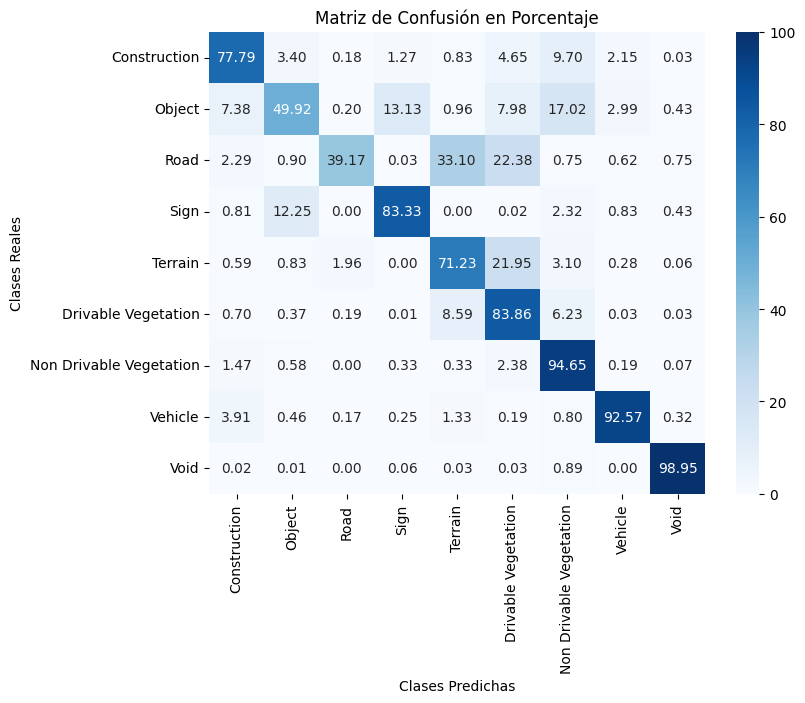

In [71]:
plot_confusion_matrix_percentage(preds_con, labels_list, num_classes=9)

In [42]:
# Crea la matriz de confusión con todas las clases posibles
num_classes = 9
cm = confusion_matrix(labels_list.flatten(), preds_con, labels=np.arange(num_classes))

# Mostrar como matriz cruda
print("Matriz de Confusión (valores absolutos):")
print(cm)

# Mostrar fila específica
print("\nFila de la clase real 2 (Road):")
print(f"Etiquetas reales == 2: {np.sum(labels_list.flatten() == 2)}")
print(f"Predicciones para esos puntos:", np.unique(preds_con[labels_list.flatten() == 2], return_counts=True))
print(cm[2])

Matriz de Confusión (valores absolutos):
[[ 994583   10195    3495     972    6737   57684   78621    5997      12]
 [  39654   63941    1696   13544    9376   33822   33390    1793       2]
 [   1329     157   86938       0   43976    9448     543     815       0]
 [  14466   13281      61   64451      68     645   17767     253       2]
 [   9076     376   52244       0 1439094  578668   18300    4732       0]
 [  34908    4213   39461      28  304462 3693649  154194    1459       3]
 [  93347   18483    1206    4530   14403  351450 6981159    3097     710]
 [  22194    3721     571     803    3530    1504    7279  226155       1]
 [    503     260    1323     468    1305    1347    5300     443   55351]]

Fila de la clase real 2 (Road):
Etiquetas reales == 2: 143206
Predicciones para esos puntos: (array([0, 1, 2, 4, 5, 6, 7]), array([ 1329,   157, 86938, 43976,  9448,   543,   815]))
[ 1329   157 86938     0 43976  9448   543   815     0]


In [62]:
visualizar_comparacion_segmentacion(points_list, labels_list, preds_list, indice=321) #21 22 70 105 306 701 438

In [46]:
import torch

# Guardar los pesos del modelo
torch.save(model.state_dict(), 'pointnet2_remission_v1_GELU.pth')